In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
plt.style.use('fivethirtyeight')

In [2]:
import keras
print('tensorflow:',tf.__version__)
print('keras:',keras.__version__)

tensorflow: 2.8.4
keras: 2.8.0


In [3]:
security = 'META'
df = yf.download(security)
his_period = 60

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-09,319.420013,324.179993,318.799988,320.549988,320.549988,16103100
2023-11-10,319.940002,329.100006,319.459991,328.769989,328.769989,19096200
2023-11-13,326.200012,332.329987,325.700012,329.190002,329.190002,16908900
2023-11-14,334.540009,338.100006,333.329987,336.309998,336.309998,17179400
2023-11-15,337.929993,338.399994,330.019989,332.709991,332.709991,14531200
2023-11-16,329.369995,334.579987,326.380005,334.190002,334.190002,18932600
2023-11-17,330.260010,335.500000,329.350006,335.040009,335.040009,14494400
2023-11-20,334.890015,341.869995,334.190002,339.970001,339.970001,16960500
2023-11-21,338.329987,339.899994,335.899994,336.980011,336.980011,12027900


In [5]:
plt.figure(figsize=(16,8), dpi=800)
plt.title('{} Close Price History'.format(security))
plt.plot(df['Close'], linewidth=2.5)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
# 使用AutoDateLocator自动确定日期的显示间隔
date_locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(date_locator)
# 设置日期的显示格式为"%Y-%m"，即年份-月份
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.savefig('{}.png'.format(security))


plt.show()

In [6]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil( len(dataset) * .8 )

training_data_len

2319

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.05624914],
       [0.04472493],
       [0.03641103],
       ...,
       [0.88418166],
       [0.87597755],
       [0.8883523 ]])

In [8]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(his_period, len(train_data)):
    x_train.append(train_data[i-his_period:i, 0])
    y_train.append(train_data[i, 0])


In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2259, 60, 1)

In [11]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(60, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
# model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# 训练 & 保存模型。
model.fit(x_train, y_train, batch_size=300000, epochs=1000)
model.save_weights('{}_lstm_model.h5'.format(security))

Epoch 1/1000


1/1 [==============================] - 16s 16s/step - loss: 0.1483
Epoch 2/1000
1/1 [==============================] - 0s 162ms/step - loss: 0.0451
Epoch 3/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.0049
Epoch 4/1000
1/1 [==============================] - 0s 104ms/step - loss: 0.0419
Epoch 5/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.0097
Epoch 6/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.0039
Epoch 7/1000
1/1 [==============================] - 0s 102ms/step - loss: 0.0124
Epoch 8/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.0182
Epoch 9/1000
1/1 [==============================] - 0s 174ms/step - loss: 0.0177
Epoch 10/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.0130
Epoch 11/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.0073
Epoch 12/1000
1/1 [==============================] - 0s 180ms/step - loss: 0.0034
Epoch 13/1000
1/1 [=======================

In [14]:
#直接载入权重模型。
# model.load_weights("VNQ_lstm_model.h5")

In [15]:
test_data = scaled_data[training_data_len - his_period:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(his_period, len(test_data)):
    x_test.append(test_data[i-his_period:i, 0])

In [16]:
x_test = np.array(x_test)

In [17]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(579, 60, 1)

In [18]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [19]:
rmse=np.sqrt(((predictions - y_test) ** 2).mean())
rmse

12.911759415445628

In [20]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\Steven Chen\AppData\Local\Temp\ipykernel_15488\2657761684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


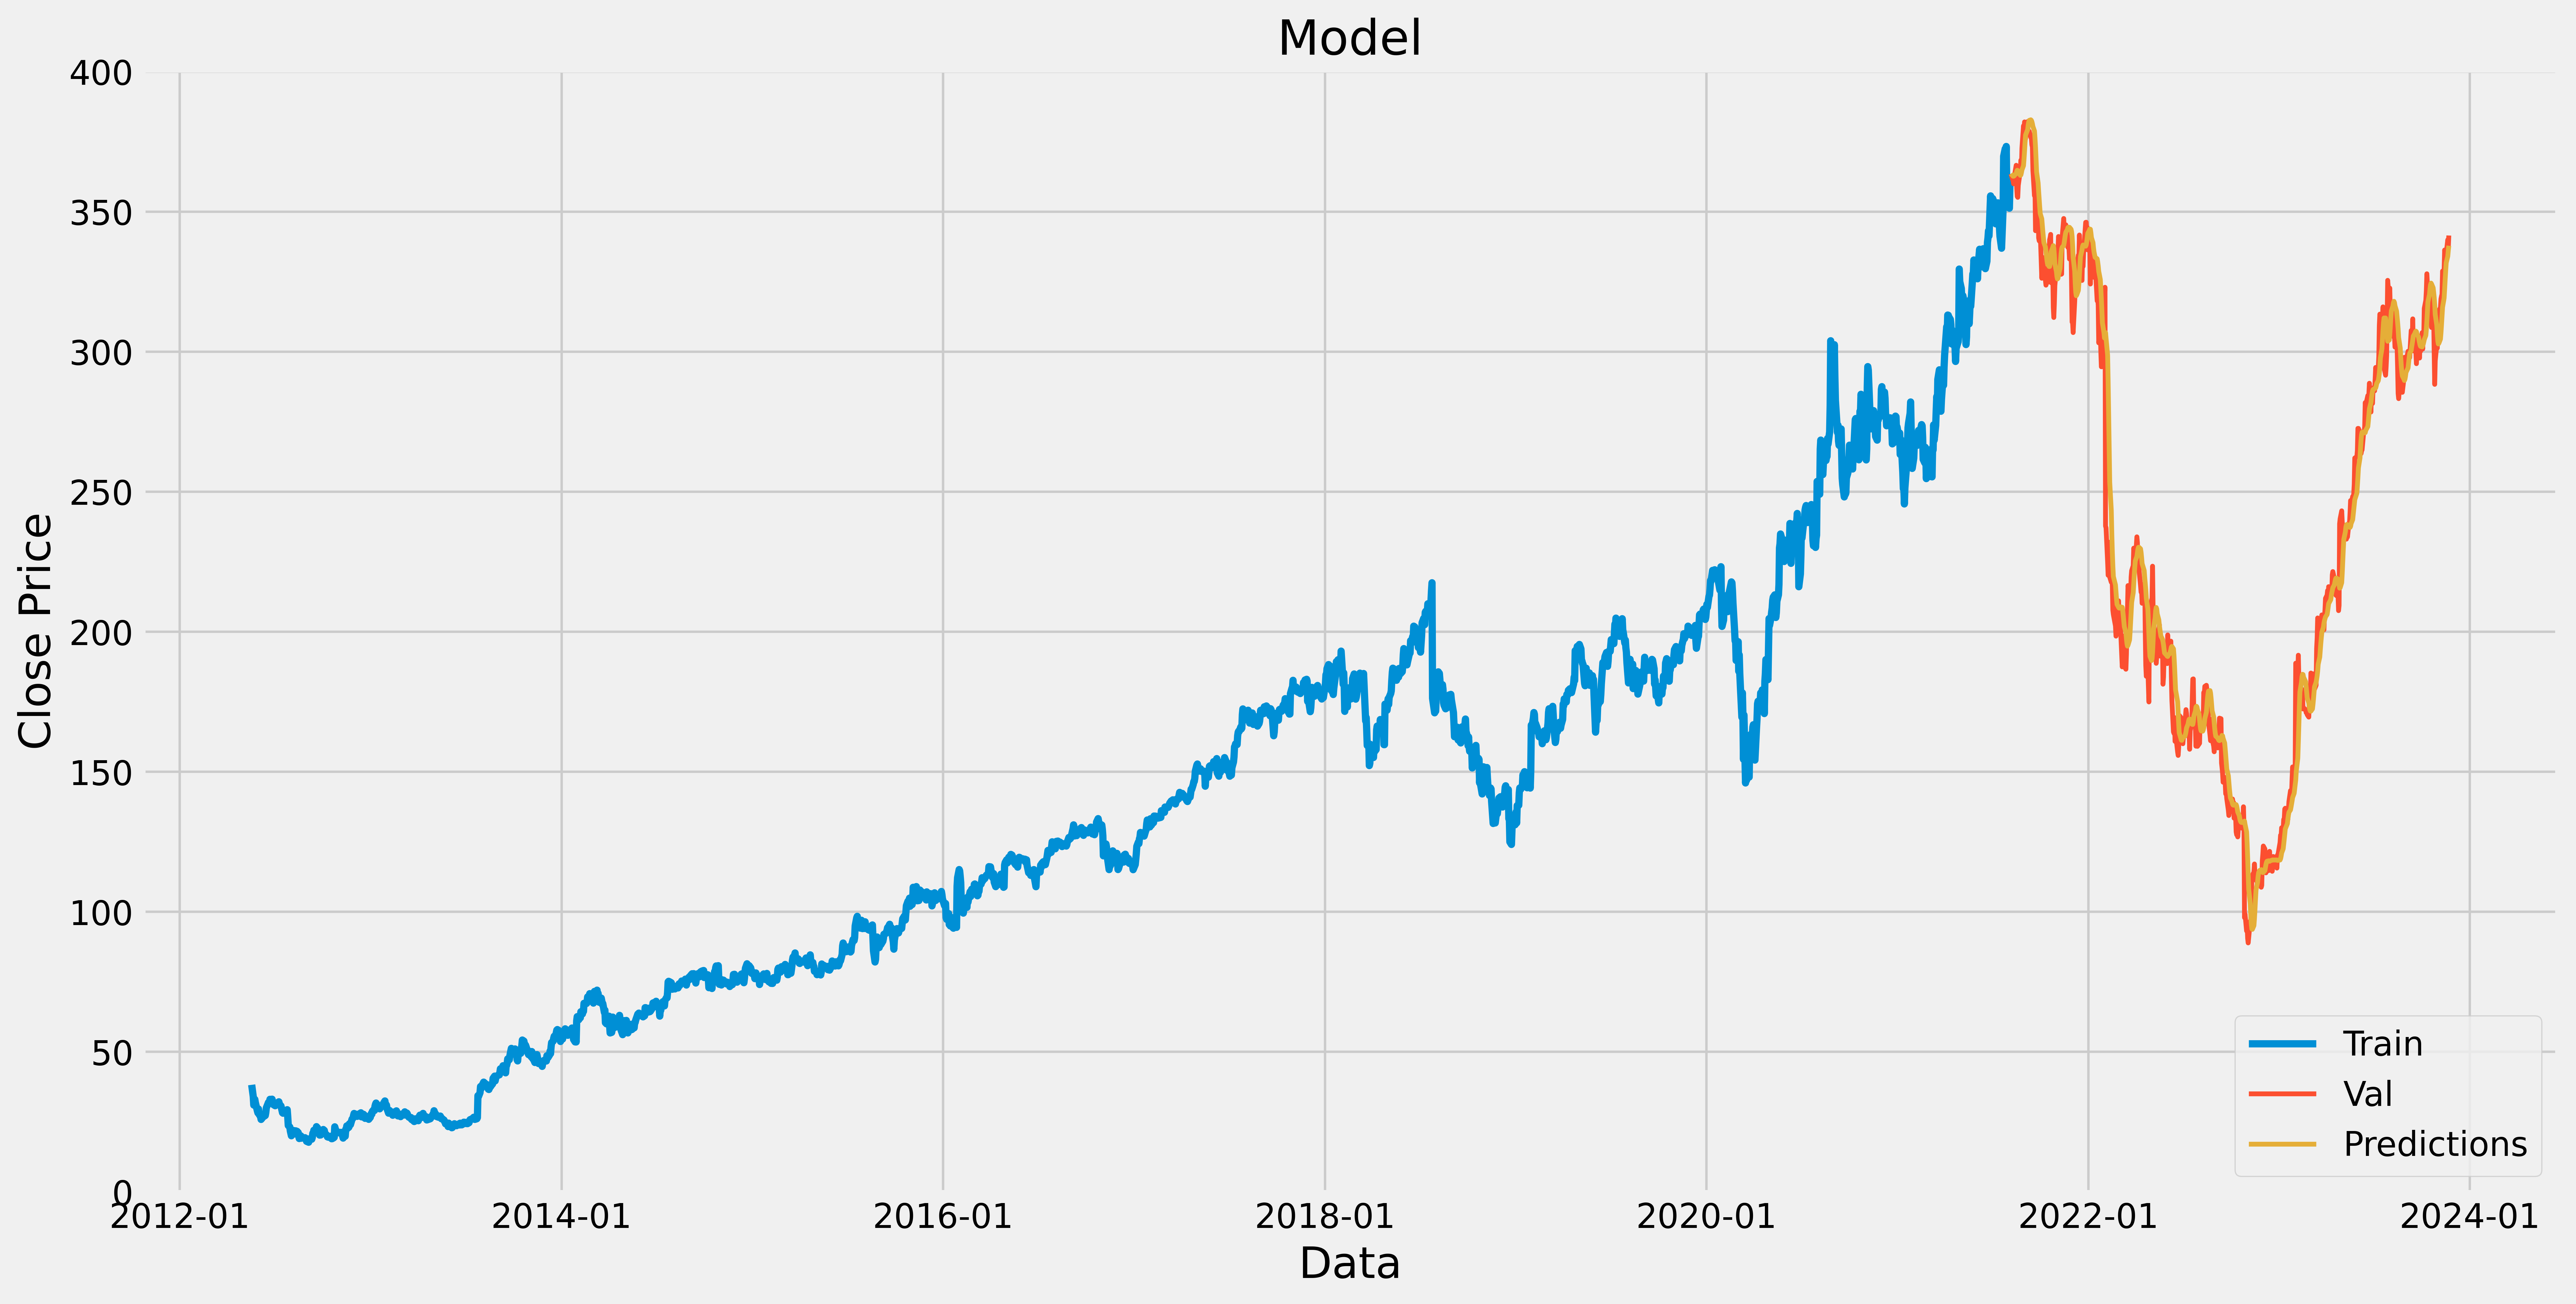

In [21]:
plt.figure(figsize=(16, 8), dpi=600)
plt.title('Model')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'], linewidth=3)
plt.plot(valid[['Close', 'Predictions']], linewidth=2)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# 使用AutoDateLocator自动确定日期的显示间隔
date_locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(date_locator)
# 设置日期的显示格式为"%Y-%m"，即年份-月份
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.savefig("{}_LSTM_predict.jpg".format(security))
plt.show()

In [22]:
last_days = df.filter(['Close'])[-his_period:].values
last_days_scaled = scaler.transform(last_days)
X_test = []
X_test.append(last_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[339.3202]]
